# Task 1

---

## Web scraping and analysis

We will use a package called `BeautifulSoup` to collect the data from the web. Once we've collected our data and saved it into a local `.csv` file we will start with our analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link:[https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import csv
import random

In [4]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [9]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | Easy check in a T5. Galleri...
1,"Not Verified | Flight delayed by an hour, it ..."
2,Not Verified | The staff are very rude and not...
3,✅ Trip Verified | Good domestic flight operat...
4,Not Verified | Failed at all basic travel fund...


In [8]:
df.to_csv("data/BA_reviews.csv")

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

The next thing that we will do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

In [10]:
# Read the CSV file
data = pd.read_csv("data/BA_reviews.csv")

# Filter rows with "✅ Trip Verified" in the beginning
filtered_data = data[data['reviews'].str.startswith('✅ Trip Verified')]

filtered_data.loc[:, 'reviews'] = filtered_data['reviews'].str.replace('✅ Trip Verified |', '').str.strip()

filtered_data.to_csv('filtered_reviews.csv', index=False)

In [11]:
data = pd.read_csv('filtered_reviews.csv')

# Get the number of rows in the DataFrame
num_rows = data.shape[0]

print(f"Number of rows in the CSV file: {num_rows}")

Number of rows in the CSV file: 797


In [12]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from gensim import corpora, models


# Preprocess the text data
preprocessed_text_data = []
for review in data['reviews']:
    tokens = word_tokenize(review.lower())
    tokens = [token for token in tokens if token not in string.punctuation]
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    preprocessed_text_data.append(tokens)

# Create a dictionary and corpus
dictionary = corpora.Dictionary(preprocessed_text_data)
corpus = [dictionary.doc2bow(text) for text in preprocessed_text_data]

# Build the LDA model
num_topics = 5  # You can adjust the number of topics
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

In [13]:
# Extract topics and associated words
topics_words = []
for topic_num, topic_words in lda_model.print_topics():
    words = topic_words.split('"')[1::2]  # Extract odd elements which are the words
    topics_words.append(words)

# Print the list of words for each topic
for i, words in enumerate(topics_words):
    print(f"Topic {i + 1}: {words}")


Topic 1: ['seat', 'flight', 'class', 'food', 'business', 'seats', 'crew', 'cabin', 'london', 'good']
Topic 2: ['flight', 'ba', '’', 'london', 'time', 'service', 'us', 'crew', 'british', 'back']
Topic 3: ['flight', 'ba', 'london', 'would', '’', 'service', 'hours', 'time', 'could', "n't"]
Topic 4: ['flight', 'ba', 'service', 'staff', 'one', 'customer', 'london', '’', 'class', 'would']
Topic 5: ['flight', 'ba', 'good', 'service', 'food', 'time', 'economy', 'crew', 'class', 'business']


In [14]:
import pandas as pd
from collections import Counter
from nltk.tokenize import word_tokenize
import string

# Load the CSV file into a DataFrame
data = pd.read_csv('filtered_reviews.csv')


# Initialize a counter to store the frequency of topic words
topic_word_counts = Counter()

for topic_words in topics_words:
    topic_word_counts.update(topic_words)
    
# Iterate through the reviews and count the frequency of topic words
for review in data['reviews']:
    tokens = word_tokenize(review.lower())
    tokens = [token for token in tokens if token not in string.punctuation]
    for token in tokens:
        if token in topic_words:
            topic_word_counts[token] += 1

# Sort the dictionary by frequency in descending order
sorted_topic_word_counts = dict(sorted(topic_word_counts.items(), key=lambda item: item[1], reverse=True))

# Print the sorted dictionary
for word, count in sorted_topic_word_counts.items():
    print(f"{word}: {count}")


flight: 1454
ba: 881
service: 566
crew: 382
time: 373
food: 372
class: 351
good: 348
business: 315
economy: 228
london: 4
’: 3
would: 2
seat: 1
seats: 1
cabin: 1
us: 1
british: 1
back: 1
hours: 1
could: 1
n't: 1
staff: 1
one: 1
customer: 1


In [15]:
# List of topic words to exclude
words_to_exclude = ["’", "n\'t","verified"]

# Remove the topic words to exclude from the dictionary
for word in words_to_exclude:
    if word in sorted_topic_word_counts:
        del sorted_topic_word_counts[word]

words = list(sorted_topic_word_counts.keys())
frequencies = list(sorted_topic_word_counts.values())

csv_output_path = 'word_frequencies.csv'
with open(csv_output_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Words', 'Frequency'])
    for word, freq in zip(words, frequencies):
        csv_writer.writerow([word, freq])

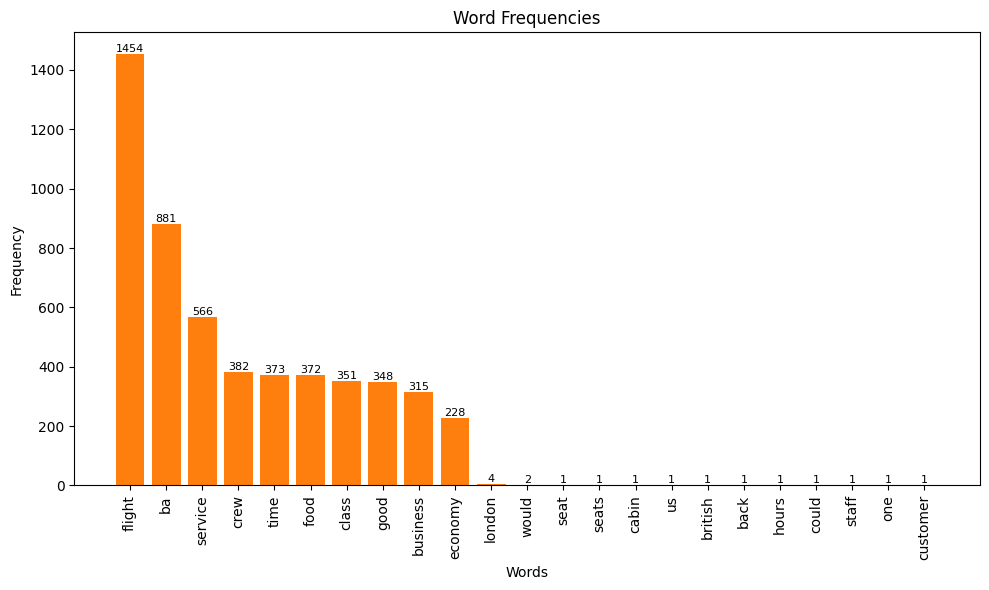

In [16]:
data = pd.read_csv("word_frequencies.csv")
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequencies')
plt.xticks(rotation=90)
plt.tight_layout()

plt.bar(words, frequencies)

# Add frequency values at the top of each bar
for i, freq in enumerate(frequencies):
    plt.text(i, freq + 0.5, str(freq), ha='center', va='bottom', fontsize=8)
    
output_path = 'word_frequencies.png'
plt.savefig(output_path, dpi=300)

plt.show()


In [17]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
data = pd.read_csv('filtered_reviews.csv')
# Initialize the VADER sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment category using VADER
def get_sentiment_vader(text):
    sentiment_scores = sia.polarity_scores(text)
    compound_score = sentiment_scores['compound']
    #print(text,compound_score)
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

data['sentiment_category_vader'] = data['reviews'].apply(get_sentiment_vader)

# Count the number of positive, neutral, and negative reviews using VADER
sentiment_counts_vader = data['sentiment_category_vader'].value_counts()

print(sentiment_counts_vader)


sentiment_category_vader
Positive    402
Negative    382
Neutral      13
Name: count, dtype: int64


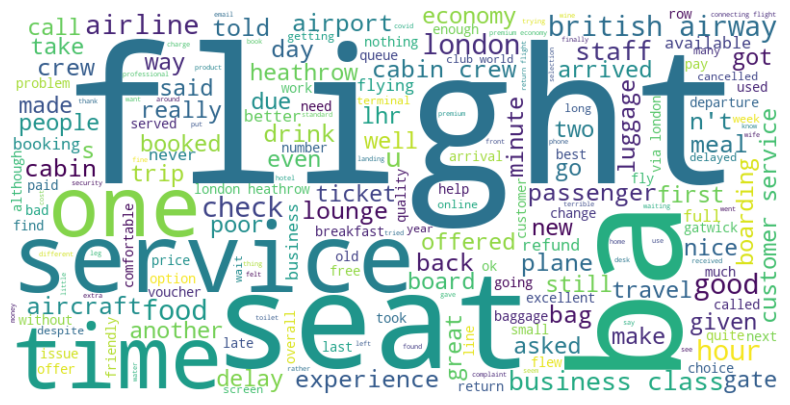

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
n_data = pd.read_csv('filtered_reviews.csv')
# Combine all preprocessed text into a single string
all_text = ' '.join([' '.join(text) for text in preprocessed_text_data])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
output_path = 'word_cloud3.png'
plt.savefig(output_path, dpi=300)

plt.show()